In [1]:
# ML_in_Finance-Bias-Variance-Tradeoff
# Author: Matthew Dixon
# Version: 1.0 (28.4.2020)
# License: MIT
# Email: matthew.dixon@iit.edu
# Notes: tested on Mac OS X running Python 3.6.9 with the following packages:
# scikit-learn=0.22.1, numpy=1.18.1, matplotlib=3.1.3, pandas=1.0.3
# Citation: Please cite the following reference if this notebook is used for research purposes:
# Dixon M.F., Halperin I. and P. Bilokon P., Machine Learning in Finance: From Theory to Practice, Springer Graduate Textbook Series, 2020.

### Overview
The purpose of this notebook is to illustrate the "bias-variance" tradeoff (see Sections 4 and 5 of Chpt 2), an important concept in statistics which concerns the tradeoff between bias (i.e. in-sample error) and variance (i.e. the change in estimate between training and validation sets) as statistical model complexity is varied. The Bias-variance tradeoff explains why complex models tend to over-fit the training data and overly simple models may underfit the training data.

In this notebook, various polynomial regression models are compared. Each input, x, denotes an angle in radians and the output is a noisy trigonometric function $y=1-cos(x) + x + \epsilon$. The regression model is of the form $\hat{y}= \beta_0 + \beta_1x + \dots + \beta_nx^n$. 200 training samples are generated for training and 80 samples are used for out-of-sample testing.


In [4]:
# Generate the training and test sets 
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 10
in_sample_x =[random.uniform(0, 400) for i in range(200)]
out_sample_x =[random.uniform(0, 400) for i in range(80)]
#Define input array with angles from 60deg to 300deg converted to radians
in_sample_x = [x*np.pi/180 for x in in_sample_x]
out_sample_x = [x*np.pi/180 for x in out_sample_x]
in_sample_x = np.sort(in_sample_x)
out_sample_x = np.sort(out_sample_x)

np.random.seed(10) 
in_sample_y = 1- np.cos(in_sample_x)+ in_sample_x + np.random.normal(0,0.6,len(in_sample_x))
out_sample_y = 1- np.cos(out_sample_x)+out_sample_x + np.random.normal(0,0.6,len(out_sample_x))
data_in = pd.DataFrame(np.column_stack([in_sample_x,in_sample_y]),columns=['x','y'])
data_out = pd.DataFrame(np.column_stack([out_sample_x,out_sample_y]),columns=['x','y'])

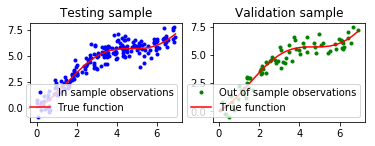

In [3]:
# Plot the datasets
plt.figure(1)
plt.subplot(221)
plt.plot(data_in['x'],data_in['y'],'.',color='blue', label="In sample observations")
plt.plot(data_in['x'],1- np.cos(in_sample_x)+ in_sample_x,color='red', label="True function")
plt.legend(loc = "lower right")
plt.title('Testing sample')
plt.subplot(222)
plt.plot(data_out['x'],data_out['y'],'.', color='green', label="Out of sample observations")
plt.plot(data_out['x'],1- np.cos(out_sample_x)+ out_sample_x,color='red', label="True function")
plt.title('Validation sample')
plt.legend(loc = "lower right")

In [5]:
# Tabulate the out-of-sample data, where each column stores the monomials or the output
for i in range(2,40):  #power of 1 is already there
    colname = 'x_%d'%i      #new var will be x_power
    data_in[colname] = data_in['x']**i
    data_out[colname] = data_out['x']**i

data_out.head()

,x,y,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,x_30,x_31,x_32,x_33,x_34,x_35,x_36,x_37,x_38,x_39
0,0.026408,0.106640,0.000697,0.000018,4.863736e-07,1.284436e-08,3.391993e-10,8.957720e-12,2.365593e-13,6.247157e-15,...,4.490295e-48,1.185816e-49,3.131554e-51,8.269940e-53,2.183961e-54,5.767496e-56,1.523105e-57,4.022280e-59,1.062221e-60,2.805158e-62
1,0.307547,1.076115,0.094585,0.029089,8.946392e-03,2.751439e-03,8.461977e-04,2.602459e-04,8.003792e-05,2.461545e-05,...,4.338697e-16,1.334355e-16,4.103772e-17,1.262104e-17,3.881568e-18,1.193766e-18,3.671395e-19,1.129128e-19,3.472603e-20,1.067990e-20
2,0.361454,-0.188782,0.130649,0.047223,1.706909e-02,6.169686e-03,2.230056e-03,8.060617e-04,2.913539e-04,1.053109e-04,...,5.515418e-14,1.993568e-14,7.205824e-15,2.604571e-15,9.414318e-16,3.402840e-16,1.229969e-16,4.445767e-17,1.606939e-17,5.808339e-18
3,0.430382,0.617816,0.185229,0.079719,3.430979e-02,1.476633e-02,6.355169e-03,2.735153e-03,1.177162e-03,5.066297e-04,...,1.036658e-11,4.461595e-12,1.920192e-12,8.264168e-13,3.556753e-13,1.530764e-13,6.588138e-14,2.835419e-14,1.220314e-14,5.252019e-15
4,0.563086,0.039189,0.317066,0.178535,1.005307e-01,5.660740e-02,3.187483e-02,1.794827e-02,1.010642e-02,5.690780e-03,...,3.290329e-08,1.852738e-08,1.043251e-08,5.874397e-09,3.307790e-09,1.862570e-09,1.048787e-09,5.905570e-10,3.325343e-10,1.872454e-10


### Model fitting and evaluation

In [6]:
# fit the models with increasing polynomial order (i.e. complexity)
from sklearn.linear_model import LinearRegression
def linear_regression(data1, data2, power, models_to_plot):
    #initialize predictors:
    predictors=['x']
    if power>=2:
        predictors.extend(['x_%d'%i for i in range(2,power+1)])
    
    #Fit the model
    linreg = LinearRegression(normalize=True)
    linreg.fit(data1[predictors],data1['y'])
    y_pred = linreg.predict(data1[predictors])
    y_pred_out = linreg.predict(data2[predictors])
    
    #Check if a plot is to be made for the entered power
    if power in models_to_plot:
        plt.subplot(models_to_plot[power])
        plt.tight_layout()
        plt.plot(data1['x'],y_pred, color = 'red')
        plt.plot(data1['x'],data1['y'],'.', color ='blue' )
        plt.title('Testing sample: Plot for power: %d'%power)
        plt.subplot(models_to_plot[power]+1)
        plt.tight_layout()
        plt.plot(data1['x'],y_pred, color = 'red')
        plt.plot(data2['x'],data2['y'],'.', color = 'green')
        plt.title('Validation sample: Plot for power: %d'%power)
    
    #Return the result in pre-defined format
    rss = sum((y_pred-data1['y'])**2)/len(y_pred)
    cvrss = sum((y_pred_out-data2['y'])**2)/len(y_pred_out)
    ret = [rss, cvrss]
    ret.extend([linreg.intercept_])
    ret.extend(linreg.coef_)
    return ret

,rss,cross-rss,intercept,coef_x_1,coef_x_2,coef_x_3,coef_x_4,coef_x_5,coef_x_6,coef_x_7,...,coef_x_30,coef_x_31,coef_x_32,coef_x_33,coef_x_34,coef_x_35,coef_x_36,coef_x_37,coef_x_38,coef_x_39
model_pow_1,0.800339,0.749432,1.14103,0.925514,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_2,0.441914,0.439936,-0.16336,2.07199,-0.161242,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_3,0.403019,0.365387,-0.697114,2.9661,-0.478099,0.0298607,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_4,0.339322,0.304723,0.138781,0.732342,0.932694,-0.279317,0.0217894,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_5,0.339297,0.305983,0.120467,0.804455,0.861332,-0.252149,0.017427,0.000248682,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_6,0.339292,0.305934,0.12903,0.75739,0.927931,-0.290267,0.0276666,-0.00104157,6.15296e-05,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_7,0.337647,0.313533,0.281345,-0.407591,3.18793,-2.09885,0.742014,-0.148341,0.0152612,-0.00061955,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_8,0.336822,0.319336,0.163342,0.821389,0.0740414,1.18978,-1.02688,0.377864,-0.0723522,0.00702402,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_9,0.336295,0.323473,0.26612,-0.507232,4.18162,-4.2155,2.70321,-1.10458,0.278917,-0.041944,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_10,0.334614,0.32901,0.4528,-3.5123,15.6836,-23.2323,19.4385,-9.76606,3.04374,-0.592394,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


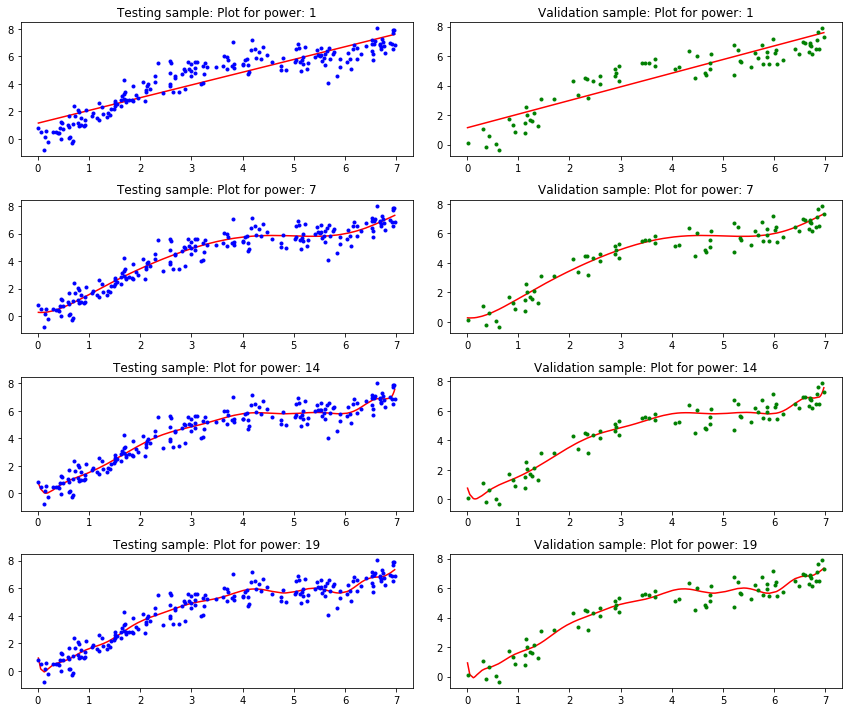

In [7]:
# Initialize a dataframe to store the results:
col = ['rss', 'cross-rss','intercept'] + ['coef_x_%d'%i for i in range(1,40)]
ind = ['model_pow_%d'%i for i in range(1,40)]
coef_matrix_simple = pd.DataFrame(index=ind, columns=col)

# Define the powers for which a plot is required:
models_to_plot = {1:421,7:423,14:425,19:427}

# Iterate through all powers and assimilate results
for i in range(1,40):
    coef_matrix_simple.iloc[i-1,0:i+3] = linear_regression(data_in, data_out, power=i, models_to_plot=models_to_plot)
coef_matrix_simple

### Illustrate the bias-variance tradeoff

The in-sample MSE (blue) and out-of-sample MSE (green) are shown for each of the models (ordered by complexity). Note that only the first 30 models are shown. The in-sample MSE (bias) is observed to decrease with complexity. For less complex models, the in-sample MSE is paradoxically observed to be higher than the out-of-sample MSE, indicating that the model is underfitting. However, for the most complex models, the out-of-sample error is significantly larger than the in-sample error (variance).

Text(0,0.5,'MSE')

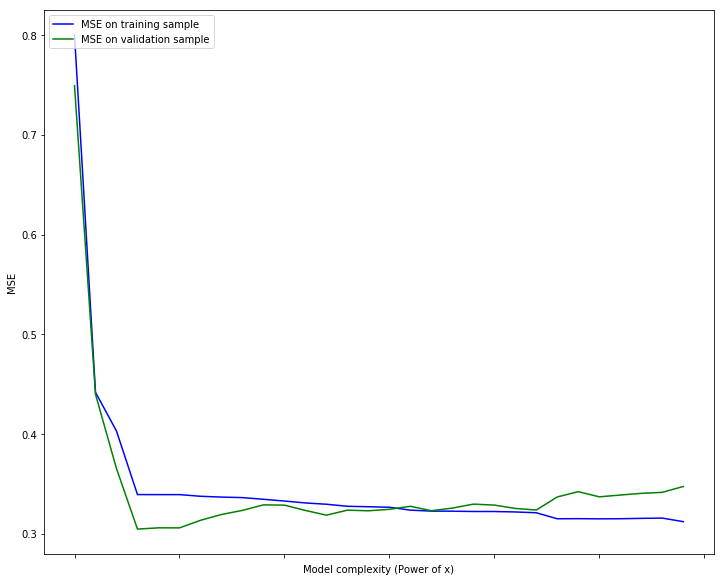

In [8]:
ax = coef_matrix_simple['rss'][0:30].plot(color = 'blue', label='MSE on training sample')
coef_matrix_simple['cross-rss'][0:30].plot(ax=ax, color = 'green',  label='MSE on validation sample')
ax.legend( loc='upper left')
ax.set_xlabel("Model complexity (Power of x)")
ax.set_ylabel("MSE")